In [2]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
import scipy.stats
from scipy.stats import poisson
import seaborn as sns
import sklearn.neighbors
import matplotlib.pyplot as plt

import Levenshtein

import sys
sys.path.append('..')
from lib import *

plt.style.use('../peptidome.mplstyle')

In [3]:
ks = [8, 9, 10, 11]

In [4]:
selfset = {k:set(count_kmers_proteome(human, k, clean=True)) for k in ks}

In [ ]:
# only human host
df_t = load_iedb_tcellepitopes(human_only=True)
print(df_t.shape[0])

In [1]:
# only MHC I epitopes
df_t = df_t[df_t['MHC', 'Class']=='I']
print(df_t.shape[0])

NameError: name 'df_t' is not defined

In [ ]:
# only epitopes of lengths in k
mask = df_t['Epitope', 'Description'].apply(len).isin(ks)
df_t = df_t[mask]
print(df_t.shape[0])

In [ ]:
df_t['MHC', 'Class'].value_counts()

In [6]:
# no host epitopes
host = 'Homo sapiens'
mask = ~df_t['Epitope', 'Parent Species'].str.contains(host, na=False)
df_t = df_t[mask]
print(df_t.shape[0])

63601


In [7]:
# exclude autoimmune / allergy / cancer epitopes
mask = ~(df_t['1st in vivo Process', 'Process Type'].isin(['Occurrence of autoimmune disease', 
                                                           'Occurrence of allergy',
                                                           'Occurrence of cancer']))
df_t = df_t[mask]
print(df_t.shape[0])

57451


In [8]:
# only include epitopes of viral origin
#mask = df_t['Epitope', 'Parent Species'].str.contains('virus')
#df_t = df_t[mask]
#print(df_t.shape[0])

In [9]:
df_t['Assay'][['Assay Group', 'Method/Technique']].value_counts().head(20)

Assay Group               Method/Technique                 
IFNg release              ELISPOT                              32284
qualitative binding       multimer/tetramer                     6572
IFNg release              ICS                                   4600
cytotoxicity              51 chromium                           3687
IFNg release              ELISA                                 1745
TNFa release              ICS                                    989
cytotoxicity              in vitro assay                         953
activation                biological activity                    906
proliferation             3H-thymidine                           654
IL-2 release              ICS                                    457
dissociation constant KD  surface plasmon resonance (SPR)        443
T cell binding            High throughput multiplexed assay      416
degranulation             biological activity                    343
off rate                  binding assay    

In [10]:
df_t['Assay', 'Method/Technique'].value_counts().head(10)

ELISPOT                            32378
multimer/tetramer                   6572
ICS                                 6446
51 chromium                         3687
ELISA                               2307
biological activity                 1341
in vitro assay                      1033
binding assay                        867
3H-thymidine                         654
surface plasmon resonance (SPR)      443
Name: (Assay, Method/Technique), dtype: int64

In [11]:
# exclude rare assay types
mask = df_t[('Assay', 'Method/Technique')].isin(df_t[('Assay', 'Method/Technique')].value_counts().head(5).index)
df_t_f = df_t[mask]

In [12]:
d0 = df_t_f['Epitope', 'Description'].apply(lambda x: x in selfset[len(x)])

In [13]:
df_t_f['Epitope', 'Parent Species'].value_counts().head(20)

Vaccinia virus                                     22213
Hepacivirus C                                       3620
Severe acute respiratory syndrome coronavirus 2     3245
Human betaherpesvirus 5                             2951
Human gammaherpesvirus 4                            2938
Dengue virus                                        1585
Hepatitis B virus                                   1515
Influenza A virus                                   1446
Plasmodium falciparum                               1051
Mycobacterium tuberculosis                           923
Human immunodeficiency virus 1                       712
Human orthopneumovirus                               673
Yellow fever virus                                   673
Alphapapillomavirus 9                                575
Human betaherpesvirus 6B                             398
Human alphaherpesvirus 1                             324
Lassa mammarenavirus                                 320
Trypanosoma cruzi              

In [14]:
df_t_f[df_t_f['Assay', 'Method/Technique']=='ELISPOT']['Assay', 'Assay Group'].value_counts()

IFNg release          32284
granzyme B release       57
IL-10 release            16
TNF release              12
IL-2 release              5
IL-4 release              2
IL-5 release              1
IL-17 release             1
Name: (Assay, Assay Group), dtype: int64

In [15]:
df_t_f[d0]['Epitope', 'Parent Species'].value_counts()

Vaccinia virus                                     104
Human endogenous retrovirus K                       13
Human betaherpesvirus 5                             10
Mycobacterium tuberculosis                           3
Human betaherpesvirus 6B                             3
Mus musculus                                         2
Leishmania major                                     2
Human gammaherpesvirus 8                             1
Plasmodium falciparum                                1
Rattus norvegicus                                    1
Sus scrofa                                           1
Dengue virus                                         1
bacterium JGI 053                                    1
Severe acute respiratory syndrome coronavirus 2      1
Name: (Epitope, Parent Species), dtype: int64

In [16]:
df_t_f[d0]['1st in vivo Process', 'Process Type'].value_counts()

Administration in vivo                                                             131
No immunization                                                                     32
Occurrence of infectious disease                                                    21
Exposure with existing immune reactivity without evidence for disease                8
Environmental exposure to endemic/ubiquitous agent without evidence for disease      5
Name: (1st in vivo Process, Process Type), dtype: int64

In [17]:
pos_d0 = df_t_f[d0][[('Assay', 'Method/Technique'),
                     ('Assay', 'Positive')]].groupby(('Assay', 'Method/Technique')).agg('mean')
pos_d0_count = df_t_f[d0][[('Assay', 'Method/Technique'),
                     ('Assay', 'Positive')]].groupby(('Assay', 'Method/Technique')).agg('count')

In [18]:
pos_all = df_t_f[[('Assay', 'Method/Technique'),
                  ('Assay', 'Positive')]].groupby(('Assay', 'Method/Technique')).agg('mean')
pos_all_count = df_t_f[[('Assay', 'Method/Technique'),
                  ('Assay', 'Positive')]].groupby(('Assay', 'Method/Technique')).agg('count')

In [19]:
dfm = pd.merge(pos_d0, pos_all, how='inner', left_index=True, right_index=True, suffixes=['_d0', '_all'])
dfm

,Assay_d0,Assay_all
,Positive,Positive
"(Assay, Method/Technique)",,
51 chromium,0.666667,0.783293
ELISA,0.857143,0.697443
ELISPOT,0.013072,0.202699
ICS,0.600000,0.695315
multimer/tetramer,0.269231,0.718351


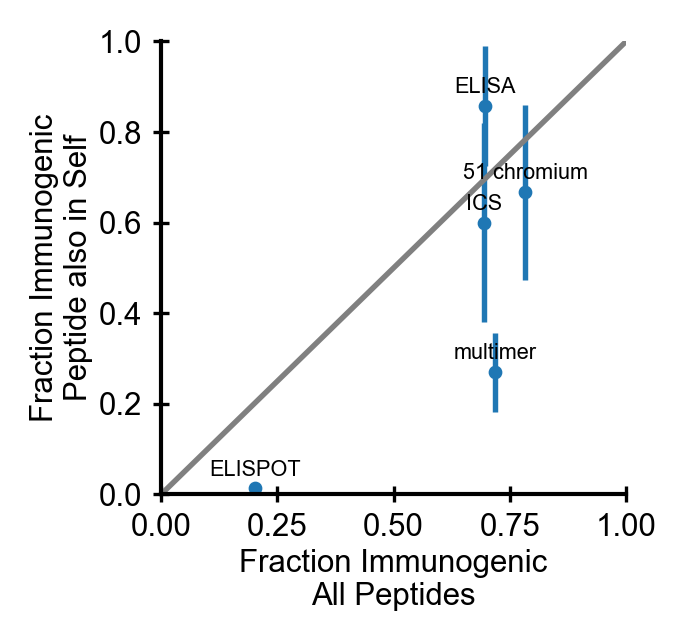

In [20]:
fig = plt.figure(figsize=(2, 2))
xs = dfm['Assay_all', 'Positive']
ys = dfm['Assay_d0', 'Positive']
counts = pos_d0_count.loc[xs.index]['Assay', 'Positive']
counts_x = pos_all_count.loc[xs.index]['Assay', 'Positive']
yerr = np.where(ys==1, 0.25, (ys*(1-ys)/counts)**.5)
xerr = (xs*(1-xs)/counts_x)**.5
labels = dfm.index
plt.errorbar(xs, ys, yerr=yerr, xerr=xerr, fmt='o')

for x, y, label in zip(xs, ys, labels):
    plt.annotate(label.split('/')[0], (x, y+0.02),
                 ha='center', va='bottom', size='xx-small')

plt.plot([0, 1], [0, 1], '-', c='.5')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.xlabel('Fraction Immunogenic\nAll Peptides')
plt.ylabel('Fraction Immunogenic\nPeptide also in Self')
fig.savefig(figuredir + 'assays.svg')